## Ultimate 2026 Ski Holiday — Analysis Notebook

This notebook implements the plan from `PLAN.md` 


### Step 0 — Terminal setup (run these in macOS Terminal)

1) Create and activate a virtual environment (optional but recommended):
```bash
cd /Users/neildadhich/Desktop/Datathon
python3 -m venv .venv
source .venv/bin/activate
```

2) Install Python packages:
```bash
pip install --upgrade pip
pip install pandas numpy matplotlib seaborn scikit-learn python-dateutil
```

3) Launch Jupyter (if not already open in Cursor):
```bash
python -m pip install jupyter
jupyter notebook | cat
```

After this, open `notebook.ipynb` and run cells in order.


In [38]:
# Step 1 — Imports and environment check
# This cell imports the libraries we need and prints their versions.

import sys
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from dateutil import parser as dateparser

print("Python:", sys.version)
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)



Python: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.6.1-arm64-arm-64bit-Mach-O
pandas: 2.3.2
numpy: 2.2.6
matplotlib: 3.10.6
seaborn: 0.13.2


In [39]:
# Step 2 — Configuration: paths, resorts, stations, week anchors, holidays
# This centralizes constants to avoid mistakes later. Adjust here if needed.

from datetime import date, timedelta

# Paths
DATA_DIR = "/Users/neildadhich/Desktop/Datathon"
CLIMATE_CSV = f"{DATA_DIR}/climate.csv"
VISITATION_CSV = f"{DATA_DIR}/visitation.csv"

# Resort list (column names in visitation.csv)
RESORTS = [
    "Mt. Baw Baw",
    "Mt. Stirling",
    "Mt. Hotham",
    "Falls Creek",
    "Mt. Buller",
    "Selwyn",
    "Thredbo",
    "Perisher",
    "Charlotte Pass",
]

# Station mapping (as per PLAN.md)
STATION_TO_RESORT = {
    71032: ["Thredbo"],
    71075: ["Perisher"],
    72161: ["Selwyn"],
    83024: ["Mt. Buller", "Mt. Stirling"],
    83084: ["Falls Creek"],
    83085: ["Mt. Hotham"],
    85291: ["Mt. Baw Baw"],
}

# Special mapping
SPECIAL_AVERAGES = {
    "Charlotte Pass": [71032, 71075],  # average Thredbo + Perisher
}

# Season week anchors (reference starts; we will shift to 2026 dates later)
WEEK_STARTS_REF = [
    (1, (6, 9)),
    (2, (6, 16)),
    (3, (6, 23)),
    (4, (6, 30)),
    (5, (7, 7)),
    (6, (7, 14)),
    (7, (7, 21)),
    (8, (7, 28)),
    (9, (8, 4)),
    (10, (8, 11)),
    (11, (8, 18)),
    (12, (8, 25)),
    (13, (9, 1)),
    (14, (9, 8)),
    (15, (9, 15)),
]

# 2026 school holidays (VIC, NSW) and King's Birthday note
HOLIDAYS_2026 = {
    "VIC_T2": {"start": date(2026, 6, 27), "end": date(2026, 7, 12)},
    "NSW_T2": {"start": date(2026, 7, 4),  "end": date(2026, 7, 19)},
    "KINGS_BDAY": {"note": "Second Monday in June; opening weekend spike"},
}

print("Config loaded. Resorts:", RESORTS)
print("Stations mapped:", STATION_TO_RESORT)
print("Special averages:", SPECIAL_AVERAGES)
print("Week starts (reference):", WEEK_STARTS_REF[:3], "... total:", len(WEEK_STARTS_REF))
print("Holidays 2026:", HOLIDAYS_2026)



Config loaded. Resorts: ['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass']
Stations mapped: {71032: ['Thredbo'], 71075: ['Perisher'], 72161: ['Selwyn'], 83024: ['Mt. Buller', 'Mt. Stirling'], 83084: ['Falls Creek'], 83085: ['Mt. Hotham'], 85291: ['Mt. Baw Baw']}
Special averages: {'Charlotte Pass': [71032, 71075]}
Week starts (reference): [(1, (6, 9)), (2, (6, 16)), (3, (6, 23))] ... total: 15
Holidays 2026: {'VIC_T2': {'start': datetime.date(2026, 6, 27), 'end': datetime.date(2026, 7, 12)}, 'NSW_T2': {'start': datetime.date(2026, 7, 4), 'end': datetime.date(2026, 7, 19)}, 'KINGS_BDAY': {'note': 'Second Monday in June; opening weekend spike'}}


In [40]:
# Step 3 — Load visitation data and tidy to long format
# This reads visitation.csv, validates columns, reshapes wide->long, and prints a preview.

expected_cols = ["Year", "Week"] + RESORTS
vis_df = pd.read_csv(VISITATION_CSV)

# Basic checks
missing = [c for c in expected_cols if c not in vis_df.columns]
if missing:
    raise ValueError(f"Missing columns in visitation.csv: {missing}")

# Melt to long format: one row per Year×Week×Resort with VisitorDays value
vis_long = (
    vis_df.melt(id_vars=["Year", "Week"], value_vars=RESORTS,
                var_name="Resort", value_name="VisitorDays")
    .sort_values(["Year", "Week", "Resort"])  # easy to inspect
    .reset_index(drop=True)
)

print("Visitation long shape:", vis_long.shape)
print(vis_long.head(10))



Visitation long shape: (1485, 4)
   Year  Week          Resort  VisitorDays
0  2014     1  Charlotte Pass          408
1  2014     1     Falls Creek         2790
2  2014     1     Mt. Baw Baw          555
3  2014     1      Mt. Buller         8296
4  2014     1      Mt. Hotham         3483
5  2014     1    Mt. Stirling           60
6  2014     1        Perisher         7370
7  2014     1          Selwyn         1041
8  2014     1         Thredbo         5535
9  2014     2  Charlotte Pass          151


In [41]:
# Step 4 — Load climate data and filter to relevant stations
# This reads climate.csv, parses dates, and keeps only rows for stations we care about.

raw_climate = pd.read_csv(CLIMATE_CSV)

# Rename to simpler names
climate = raw_climate.rename(columns={
    "Bureau of Meteorology station number": "station",
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Maximum temperature (Degree C)": "tmax_c",
    "Minimum temperature (Degree C)": "tmin_c",
    "Rainfall amount (millimetres)": "rain_mm",
})

# Keep only stations in our mapping (and special-average components)
keep_station_ids = set(STATION_TO_RESORT.keys())
for stations in SPECIAL_AVERAGES.values():
    keep_station_ids.update(stations)

climate = climate[climate["station"].isin(list(keep_station_ids))].copy()

# Build a proper date column; coerce errors to NaT and drop
climate["date"] = pd.to_datetime(dict(year=climate.year, month=climate.month, day=climate.day), errors="coerce")
climate = climate.dropna(subset=["date"]).copy()

# Ensure numeric types
for col in ["tmax_c", "tmin_c", "rain_mm"]:
    climate[col] = pd.to_numeric(climate[col], errors="coerce")

print("Climate filtered shape:", climate.shape)
print(climate.head())



Climate filtered shape: (39813, 8)
   station  year  month  day  tmax_c  tmin_c  rain_mm       date
0    71075  2010      1    1     NaN     NaN      NaN 2010-01-01
1    71075  2010      1    2     NaN     NaN      NaN 2010-01-02
2    71075  2010      1    3     NaN     NaN      NaN 2010-01-03
3    71075  2010      1    4     NaN     NaN      NaN 2010-01-04
4    71075  2010      1    5     NaN     NaN      NaN 2010-01-05


In [42]:
# Step 5 — Map stations to resorts and create resort-level daily climate
# We aggregate by resort per day. For Charlotte Pass we average Thredbo and Perisher.

# Helper: build resort->station list (including special-averages handling)
from collections import defaultdict

resort_to_station = defaultdict(list)
for stn, resorts in STATION_TO_RESORT.items():
    for r in resorts:
        resort_to_station[r].append(stn)

# Add Charlotte Pass as a special average
for resort, stations in SPECIAL_AVERAGES.items():
    resort_to_station[resort] = stations

# Aggregate station readings to resort-day: mean across stations for that resort
resort_daily_list = []
for resort, stations in resort_to_station.items():
    subset = climate[climate["station"].isin(stations)].copy()
    if subset.empty:
        continue
    grouped = (
        subset.groupby("date")[["tmax_c", "tmin_c", "rain_mm"]]
              .mean(numeric_only=True)
              .reset_index()
    )
    grouped["Resort"] = resort
    resort_daily_list.append(grouped)

resort_daily = pd.concat(resort_daily_list, ignore_index=True)

# Add basic derived indicators for later scoring
resort_daily["cold_day"] = (resort_daily["tmax_c"] <= 2) | (resort_daily["tmin_c"] <= -2)
resort_daily["thaw_day"] = (resort_daily["tmax_c"] > 3)

print("Resort daily climate shape:", resort_daily.shape)
print(resort_daily.head())



Resort daily climate shape: (51189, 7)
        date  tmax_c  tmin_c  rain_mm   Resort  cold_day  thaw_day
0 2010-01-01    17.6     9.4     47.2  Thredbo     False      True
1 2010-01-02    13.8     9.3     29.2  Thredbo     False      True
2 2010-01-03    14.3     6.3      0.0  Thredbo     False      True
3 2010-01-04    14.9     5.1      0.0  Thredbo     False      True
4 2010-01-05    17.7    10.4      0.0  Thredbo     False      True


In [43]:
# Step 6 — Define season week windows for any given year
# We’ll create helper functions to build 15 week windows based on the reference anchors.

from datetime import datetime

def build_season_weeks_for_year(year: int):
    """
    Construct a list of 15 (week_index, start_date, end_date) tuples for the given year
    using the reference Month/Day anchors.
    end_date is exclusive (start + 7 days).
    """
    weeks = []
    for idx, (m, d) in WEEK_STARTS_REF:
        start = date(year, m, d)
        end = start + timedelta(days=7)
        weeks.append((idx, start, end))
    return weeks

# Example build for 2026
weeks_2026 = build_season_weeks_for_year(2026)
print("First 3 week windows for 2026:", weeks_2026[:3])



First 3 week windows for 2026: [(1, datetime.date(2026, 6, 9), datetime.date(2026, 6, 16)), (2, datetime.date(2026, 6, 16), datetime.date(2026, 6, 23)), (3, datetime.date(2026, 6, 23), datetime.date(2026, 6, 30))]


In [44]:
# Step 7 — Attach week index to each resort-day for historical seasons
# This prepares for later weekly blending and training the visitor forecast.

# We’ll tag each date with (year, week_index) if it falls in the season windows for that year.

# Build season windows for all relevant years in the climate data
all_years = sorted(resort_daily["date"].dt.year.unique())
season_windows = {y: build_season_weeks_for_year(int(y)) for y in all_years}

# Function to map a date to a (year, week_index) if within season
from bisect import bisect_left

def map_date_to_season_week(dt: pd.Timestamp):
    y = dt.year
    for idx, start, end in season_windows.get(y, []):
        if start <= dt.date() < end:
            return y, idx
    return y, None  # outside season

resort_daily["season_year"], resort_daily["season_week"] = zip(*resort_daily["date"].map(map_date_to_season_week))

print(resort_daily.head())
print("Fraction of rows within season weeks:", (resort_daily["season_week"].notna().mean()))



        date  tmax_c  tmin_c  rain_mm   Resort  cold_day  thaw_day  \
0 2010-01-01    17.6     9.4     47.2  Thredbo     False      True   
1 2010-01-02    13.8     9.3     29.2  Thredbo     False      True   
2 2010-01-03    14.3     6.3      0.0  Thredbo     False      True   
3 2010-01-04    14.9     5.1      0.0  Thredbo     False      True   
4 2010-01-05    17.7    10.4      0.0  Thredbo     False      True   

   season_year  season_week  
0         2010          NaN  
1         2010          NaN  
2         2010          NaN  
3         2010          NaN  
4         2010          NaN  
Fraction of rows within season weeks: 0.28564730703862157


In [45]:
# Step 8 — Preview: basic weekly climate aggregates (for sanity checks)
# We’ll produce a simple weekly summary (mean/ sums) to confirm mapping makes sense.

weekly_climate = (
    resort_daily.dropna(subset=["season_week"]) # keep only dates within season windows
    .groupby(["Resort", "season_year", "season_week"]) 
    .agg(
        tmax_mean=("tmax_c", "mean"),
        tmin_mean=("tmin_c", "mean"),
        rain_sum=("rain_mm", "sum"),
        cold_days=("cold_day", "sum"),
        thaw_days=("thaw_day", "sum"),
    )
    .reset_index()
)

print("Weekly climate shape:", weekly_climate.shape)
print(weekly_climate.head(10))



Weekly climate shape: (2096, 8)
           Resort  season_year  season_week  tmax_mean  tmin_mean  rain_sum  \
0  Charlotte Pass         2010          1.0   1.528571  -6.078571       7.2   
1  Charlotte Pass         2010          2.0   1.928571  -2.700000      75.4   
2  Charlotte Pass         2010          3.0   2.021429  -4.578571      40.5   
3  Charlotte Pass         2010          4.0   0.778571  -6.514286       1.8   
4  Charlotte Pass         2010          5.0   4.028571  -5.228571      42.9   
5  Charlotte Pass         2010          6.0   0.678571  -5.535714     106.9   
6  Charlotte Pass         2010          7.0   3.585714  -5.928571       0.8   
7  Charlotte Pass         2010          8.0   1.871429  -2.478571     102.5   
8  Charlotte Pass         2010          9.0   0.621429  -7.042857       3.8   
9  Charlotte Pass         2010         10.0   1.592857  -3.492857      76.8   

   cold_days  thaw_days  
0          7          2  
1          6          1  
2          5        

### Step 9 — Sanity checks (run to confirm everything looks right)
This will:
- Summarize shapes and date ranges
- List resorts present in each dataset
- Show missing-data rates and weekly coverage
- Print a final boolean indicating if checks passed


In [46]:
# Step 9 — Sanity checks code

checks = {}

# 1) Visitation long basic checks
checks["vis_long_nonempty"] = (len(vis_long) > 0)
checks["vis_long_has_all_resorts"] = set(RESORTS).issubset(set(vis_long["Resort"].unique()))

# 2) Climate filtered basic checks
checks["climate_nonempty"] = (len(climate) > 0)

# 3) Resort daily and weekly coverage
checks["resort_daily_nonempty"] = (len(resort_daily) > 0)
checks["weekly_climate_nonempty"] = (len(weekly_climate) > 0)

# 4) Week tagging coverage
coverage = float(resort_daily["season_week"].notna().mean()) if len(resort_daily) else 0.0
# Expected fraction of days inside season windows is about 15*7 / 365.25 ≈ 0.287
expected_cov = (15*7)/365.25
checks["season_week_tagged_ratio_close_to_expected"] = (abs(coverage - expected_cov) <= 0.1)

# 5) Missingness signal
missing_cols = {col: resort_daily[col].isna().mean() for col in ["tmax_c","tmin_c","rain_mm"]}
checks["reasonable_missingness"] = all(v <= 0.5 for v in missing_cols.values())

# 6) Weekly week index sanity (should be within 1..15)
weeks_set = set(weekly_climate["season_week"].unique().tolist()) if len(weekly_climate) else set()
checks["weekly_weeks_in_1_15"] = weeks_set.issubset(set(range(1,16)))

print("Shapes:")
print("  vis_long:", vis_long.shape)
print("  climate:", climate.shape)
print("  resort_daily:", resort_daily.shape)
print("  weekly_climate:", weekly_climate.shape)
print()
print("Resorts in vis_long:", sorted(vis_long["Resort"].unique().tolist()))
print("Resorts in resort_daily:", sorted(resort_daily["Resort"].unique().tolist()))
print()
print("Resort_daily date range:", str(resort_daily["date"].min()), "to", str(resort_daily["date"].max()))
print("Week tagging coverage (fraction within season weeks):", round(coverage, 3), "/ expected ~", round(expected_cov,3))
print("Weekly weeks set (should be subset of 1..15):", sorted(list(weeks_set))[:10], "...")
print("Missingness (resort_daily):", {k: round(v,3) for k,v in missing_cols.items()})
print()

all_ok = all(checks.values())
print("Checks:")
for k,v in checks.items():
    print(f"  {k}: {v}")
print("\nALL_OK:", all_ok)



Shapes:
  vis_long: (1485, 4)
  climate: (39813, 8)
  resort_daily: (51189, 9)
  weekly_climate: (2096, 8)

Resorts in vis_long: ['Charlotte Pass', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller', 'Mt. Hotham', 'Mt. Stirling', 'Perisher', 'Selwyn', 'Thredbo']
Resorts in resort_daily: ['Charlotte Pass', 'Falls Creek', 'Mt. Baw Baw', 'Mt. Buller', 'Mt. Hotham', 'Mt. Stirling', 'Perisher', 'Selwyn', 'Thredbo']

Resort_daily date range: 2010-01-01 00:00:00 to 2025-07-28 00:00:00
Week tagging coverage (fraction within season weeks): 0.286 / expected ~ 0.287
Weekly weeks set (should be subset of 1..15): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0] ...
Missingness (resort_daily): {'tmax_c': np.float64(0.032), 'tmin_c': np.float64(0.032), 'rain_mm': np.float64(0.04)}

Checks:
  vis_long_nonempty: True
  vis_long_has_all_resorts: True
  climate_nonempty: True
  resort_daily_nonempty: True
  weekly_climate_nonempty: True
  season_week_tagged_ratio_close_to_expected: True
  reasonable_missingne

### Step 10 — Rolling 7-day climate windows (historical climatology)
We compute 7-day windows for each resort and season, then aggregate across years to get expected values and uncertainty bands per calendar window.


In [47]:
# Step 10 — Rolling 7-day climate windows code

# Helper: for each resort, create daily series with full date index
resort_daily_sorted = resort_daily.sort_values(["Resort", "date"]).copy()

# Compute rolling features per resort
roll_list = []
for resort_name, grp in resort_daily_sorted.groupby("Resort"):
    g = grp.set_index("date").sort_index()
    # Ensure daily continuity (reindex to daily); keep numeric columns for roll
    idx = pd.date_range(g.index.min(), g.index.max(), freq="D")
    g = g.reindex(idx)
    g["Resort"] = resort_name

    # Rolling 7-day sums/means on key signals; min periods = 5 to allow edge windows
    window = 7
    roll = pd.DataFrame(index=g.index)
    roll["Resort"] = resort_name
    roll["cold_days_7"] = g["cold_day"].rolling(window, min_periods=5).sum()
    roll["thaw_days_7"] = g["thaw_day"].rolling(window, min_periods=5).sum()
    roll["rain_sum_7"] = g["rain_mm"].rolling(window, min_periods=5).sum()
    roll["tmax_mean_7"] = g["tmax_c"].rolling(window, min_periods=5).mean()
    roll["tmin_mean_7"] = g["tmin_c"].rolling(window, min_periods=5).mean()

    # The window is defined as the 7 days ending on this date; we also keep the start date
    roll["window_end"] = roll.index
    roll["window_start"] = roll["window_end"] - pd.to_timedelta(window-1, unit="D")

    roll_list.append(roll.reset_index(drop=True))

rolling7 = pd.concat(roll_list, ignore_index=True)

# Drop rows where the rolling window didn't have enough data
rolling7 = rolling7.dropna(subset=["cold_days_7", "rain_sum_7", "tmax_mean_7", "tmin_mean_7"]).copy()

print("Rolling7 shape:", rolling7.shape)
print(rolling7.head())



Rolling7 shape: (48303, 8)
           Resort  cold_days_7  thaw_days_7  rain_sum_7  tmax_mean_7  \
4  Charlotte Pass          0.0          5.0        76.4    15.660000   
5  Charlotte Pass          0.0          6.0        76.4    16.016667   
6  Charlotte Pass          0.0          7.0        76.4    16.342857   
7  Charlotte Pass          0.0          7.0        29.2    16.471429   
8  Charlotte Pass          0.0          7.0         0.0    17.485714   

   tmin_mean_7 window_end window_start  
4     8.100000 2010-01-05   2009-12-30  
5     8.100000 2010-01-06   2009-12-31  
6     7.771429 2010-01-07   2010-01-01  
7     7.414286 2010-01-08   2010-01-02  
8     7.600000 2010-01-09   2010-01-03  


In [48]:
# Step 11 — Climate window score and climatology aggregation
# We convert rolling features into a simple climate score and then compute expected/percentile stats per calendar window.

# Define a simple climate score: more cold days + cold-precip (rain when cold) minus thaw
# Note: This is a placeholder; we will revisit weights later.

# For a proxy of cold-precip, use rain_sum_7 scaled by share of cold days
rolling7["cold_share"] = rolling7["cold_days_7"] / 7.0
rolling7["cold_precip_proxy"] = rolling7["rain_sum_7"].fillna(0) * rolling7["cold_share"].fillna(0)

# Score components
w_cold = 1.0
w_cold_precip = 1.0
w_thaw = -0.5

rolling7["climate_score"] = (
    w_cold * rolling7["cold_days_7"].fillna(0)
    + w_cold_precip * rolling7["cold_precip_proxy"].fillna(0)
    + w_thaw * rolling7["thaw_days_7"].fillna(0)
)

# Align windows to a canonical calendar key (month, day of start)
rolling7["start_month"] = rolling7["window_start"].dt.month
rolling7["start_day"] = rolling7["window_start"].dt.day

# Aggregate climatology: expected value and 20/80 percentiles per resort and calendar window
clim_group = rolling7.groupby(["Resort", "start_month", "start_day"])  # across years
climatology = clim_group["climate_score"].agg(
    climate_mean="mean",
    climate_p20=lambda x: np.nanpercentile(x, 20),
    climate_p80=lambda x: np.nanpercentile(x, 80),
).reset_index()

print("Climatology shape:", climatology.shape)
print(climatology.head())



Climatology shape: (3294, 6)
           Resort  start_month  start_day  climate_mean  climate_p20  \
0  Charlotte Pass            1          1     -3.428571         -3.5   
1  Charlotte Pass            1          2     -3.428571         -3.5   
2  Charlotte Pass            1          3     -3.434821         -3.5   
3  Charlotte Pass            1          4     -3.434821         -3.5   
4  Charlotte Pass            1          5     -3.399107         -3.5   

   climate_p80  
0         -3.5  
1         -3.5  
2         -3.5  
3         -3.5  
4         -3.5  


### Step 12 — Visitor baseline, holiday overlaps, and 2026 weekly forecast
We’ll build per-resort weekly baselines, compute 2026 holiday overlaps, estimate uplift, and create a crowd z-score for 2026.


In [49]:
# Step 12 — Visitor baseline and 2026 weekly forecast

# 12.1 Historical weekly baseline per resort (mean across years)
hist_baseline = (
    vis_long.groupby(["Resort", "Week"])  # across all years
            ["VisitorDays"].mean()
            .rename("baseline_mean")
            .reset_index()
)

# 12.2 2026 season windows and holiday overlap per week
weeks_2026 = build_season_weeks_for_year(2026)

def overlap_fraction(a_start, a_end, b_start, b_end):
    """Compute fraction of [a_start, a_end) overlapped by [b_start, b_end)."""
    latest_start = max(a_start, b_start)
    earliest_end = min(a_end, b_end)
    overlap_days = (earliest_end - latest_start).days
    total_days = (a_end - a_start).days
    return max(0, overlap_days) / max(1, total_days)

rows = []
for week_idx, ws, we in weeks_2026:
    # VIC and NSW holiday overlaps
    vic = HOLIDAYS_2026["VIC_T2"]
    nsw = HOLIDAYS_2026["NSW_T2"]
    vic_overlap = overlap_fraction(ws, we, vic["start"], vic["end"] + timedelta(days=1))
    nsw_overlap = overlap_fraction(ws, we, nsw["start"], nsw["end"] + timedelta(days=1))
    rows.append({
        "Week": week_idx,
        "week_start": ws,
        "week_end": we,
        "vic_overlap": vic_overlap,
        "nsw_overlap": nsw_overlap,
    })

hol_2026 = pd.DataFrame(rows)

print("2026 holiday overlap (first rows):")
print(hol_2026.head())

# 12.3 Simple uplift model: estimate uplift from historical data by comparing
# weeks that overlapped historical VIC/NSW Term 2 holidays vs those that didn't.

# Build historical holiday overlaps for each Year x Week (approx using REF anchors per year)
hist_rows = []
hist_years = sorted(vis_long["Year"].unique())
# Assume historical NSW/VIC winter holidays occur similar dates (shifted by year). For simplicity we use the 2026 windows as proxies here.
for y in hist_years:
    for week_idx, ws, we in build_season_weeks_for_year(int(y)):
        vic = HOLIDAYS_2026["VIC_T2"]
        nsw = HOLIDAYS_2026["NSW_T2"]
        # Shift holidays by year delta from 2026 to y
        delta = y - 2026
        vic_shift = {"start": date(vic["start"].year + delta, vic["start"].month, vic["start"].day),
                     "end":   date(vic["end"].year   + delta, vic["end"].month,   vic["end"].day)}
        nsw_shift = {"start": date(nsw["start"].year + delta, nsw["start"].month, nsw["start"].day),
                     "end":   date(nsw["end"].year   + delta, nsw["end"].month,   nsw["end"].day)}
        vic_overlap = overlap_fraction(ws, we, vic_shift["start"], vic_shift["end"] + timedelta(days=1))
        nsw_overlap = overlap_fraction(ws, we, nsw_shift["start"], nsw_shift["end"] + timedelta(days=1))
        hist_rows.append({"Year": y, "Week": week_idx, "vic_overlap": vic_overlap, "nsw_overlap": nsw_overlap})

hist_holiday = pd.DataFrame(hist_rows)

# Merge with visitation to estimate multiplicative uplift by overlap (coarse, interpretable)
vis_h = vis_long.merge(hist_holiday, on=["Year","Week"], how="left")

# For each resort and week index, compute mean visitors by bins of overlap
def uplift_from_overlap(df, overlap_col):
    # Simple 2-bin: any overlap vs none
    df = df.copy()
    df["overlap_any"] = (df[overlap_col] > 0).astype(int)
    g = df.groupby(["Resort", "overlap_any"])['VisitorDays'].mean().unstack(fill_value=np.nan)
    # uplift = mean(overlap_any=1) / mean(overlap_any=0)
    uplift = (g.get(1) / g.get(0)).rename(f"uplift_{overlap_col}")
    return uplift

uplift_vic = uplift_from_overlap(vis_h, "vic_overlap")
uplift_nsw = uplift_from_overlap(vis_h, "nsw_overlap")

# Combine uplifts: if missing, default to 1.0 (no uplift)
uplifts = pd.concat([uplift_vic, uplift_nsw], axis=1)
uplifts = uplifts.fillna(1.0).reset_index()

print("Estimated uplifts (head):")
print(uplifts.head())

# 12.4 Build 2026 forecast per resort-week: baseline × weighted uplift × (no trend for now)
# Uplift per week combines VIC and NSW by their 2026 overlap fractions

# Create per-resort baseline for 2026 weeks by joining baseline_mean
weeks_df = pd.DataFrame({"Week": [w for w,_,_ in weeks_2026]})
baseline_2026 = weeks_df.merge(hist_baseline, on="Week", how="left")

# Expand to all resorts
all_resorts = pd.DataFrame({"Resort": RESORTS})
forecast_rows = []
for _, rrow in all_resorts.iterrows():
    resort_name = rrow["Resort"]
    # resort-specific uplifts
    up_row = uplifts[uplifts["Resort"] == resort_name]
    uvic = float(up_row["uplift_vic_overlap"].iloc[0]) if not up_row.empty else 1.0
    unsw = float(up_row["uplift_nsw_overlap"].iloc[0]) if not up_row.empty else 1.0
    # Build week table
    temp = baseline_2026.copy()
    temp["Resort"] = resort_name
    temp = temp.merge(hol_2026, on="Week", how="left")
    # multiplicative uplift blended by overlaps
    temp["uplift"] = (temp["vic_overlap"].fillna(0) * (uvic-1.0) + 1.0) * (temp["nsw_overlap"].fillna(0) * (unsw-1.0) + 1.0)
    temp["forecast_visitors_2026"] = temp["baseline_mean"] * temp["uplift"]
    forecast_rows.append(temp)

forecast_2026 = pd.concat(forecast_rows, ignore_index=True)

# 12.5 Crowd z-score within resort
forecast_2026["crowd_z"] = forecast_2026.groupby("Resort")["forecast_visitors_2026"].transform(lambda s: (s - s.mean()) / (s.std() if s.std() else 1.0))

print("2026 forecast (head):")
print(forecast_2026.head())



2026 holiday overlap (first rows):
   Week  week_start    week_end  vic_overlap  nsw_overlap
0     1  2026-06-09  2026-06-16     0.000000     0.000000
1     2  2026-06-16  2026-06-23     0.000000     0.000000
2     3  2026-06-23  2026-06-30     0.428571     0.000000
3     4  2026-06-30  2026-07-07     1.000000     0.428571
4     5  2026-07-07  2026-07-14     0.857143     1.000000
Estimated uplifts (head):
           Resort  uplift_vic_overlap  uplift_nsw_overlap
0  Charlotte Pass            0.940359            1.419958
1     Falls Creek            0.786480            1.176768
2     Mt. Baw Baw            1.287731            1.841076
3      Mt. Buller            1.086523            1.606541
4      Mt. Hotham            0.880937            1.358451
2026 forecast (head):
   Week       Resort  baseline_mean  week_start    week_end  vic_overlap  \
0     1  Mt. Baw Baw     787.363636  2026-06-09  2026-06-16          0.0   
1     1  Mt. Baw Baw    6461.636364  2026-06-09  2026-06-16          

### Step 13 — 2026 7-day windows, overlap-blended crowd, and composite score
We generate all 7-day windows in the 2026 season, join climate climatology by start date, blend weekly crowd z-scores by overlap, standardize climate, and compute a composite score.


In [50]:
# Step 13 — Compute 2026 rolling windows and composite scores

# 13.1 Build all 7-day windows within the 2026 season boundary
weeks_2026 = build_season_weeks_for_year(2026)
season_start = weeks_2026[0][1]
season_end = weeks_2026[-1][2]

win_rows = []
cur = season_start
while cur + timedelta(days=7) <= season_end:  # strictly inside season
    ws = cur
    we = cur + timedelta(days=7)
    win_rows.append({
        "window_start": ws,
        "window_end": we,
        "start_month": ws.month,
        "start_day": ws.day,
    })
    cur = cur + timedelta(days=1)

windows_2026 = pd.DataFrame(win_rows)

# 13.2 Attach climate climatology by (Resort, start_month, start_day)
# This gives expected climate_mean and bands for each resort×window
win_clim = windows_2026.assign(dummy=1).merge(
    pd.DataFrame({"Resort": RESORTS, "dummy": 1}), on="dummy", how="left"
).drop(columns=["dummy"]).merge(
    climatology, on=["Resort", "start_month", "start_day"], how="left"
)

# 13.3 Attach overlap-blended weekly crowd z-score
# For each window, compute overlap with each Week and weight that Week's crowd_z

def blended_crowd_for_resort(df_resort):
    rows = []
    f = forecast_2026[forecast_2026["Resort"] == df_resort["Resort"].iloc[0]]
    for _, w in df_resort.iterrows():
        ws, we = w["window_start"], w["window_end"]
        # compute overlaps with each 2026 week
        tot = 0.0
        acc = 0.0
        for _, wk in f.iterrows():
            ow = overlap_fraction(ws, we, wk["week_start"], wk["week_end"])  # fraction of 7 days in that week
            if ow > 0:
                acc += ow * float(wk["crowd_z"])
                tot += ow
        rows.append(acc / tot if tot > 0 else np.nan)
    return rows

blended_list = []
for resort_name, grp in win_clim.groupby("Resort"):
    vals = blended_crowd_for_resort(grp)
    temp = grp.copy()
    temp["crowd_z_blended"] = vals
    blended_list.append(temp)

win_scored = pd.concat(blended_list, ignore_index=True)

# 13.4 Standardize climate_mean per resort (z-score) for comparability
win_scored["climate_mean_z"] = win_scored.groupby("Resort")["climate_mean"].transform(lambda s: (s - s.mean()) / (s.std() if s.std() else 1.0))

# 13.5 Composite score (weights per PLAN.md)
w_snow, w_crowd, w_price, w_comfort, w_amen = 0.40, 0.30, 0.15, 0.10, 0.05
# For now, price proxy = weighted holiday overlap for the Week containing window_start (computed below)
# Determine which Week window_start falls in
week_map = pd.DataFrame(weeks_2026, columns=["Week", "week_start", "week_end"])

def start_week_overlap(row):
    ws = row["window_start"]
    wk = week_map[(week_map["week_start"] <= ws) & (ws < week_map["week_end"])].head(1)
    if wk.empty:
        return 0.0
    wk = wk.iloc[0]
    wrow = hol_2026[hol_2026["Week"] == wk["Week"]].iloc[0]
    return 0.5 * float(wrow["vic_overlap"]) + 0.5 * float(wrow["nsw_overlap"])  # equal blend

win_scored["price_proxy"] = win_scored.apply(start_week_overlap, axis=1)

# Normalize proxies per resort
win_scored["price_proxy_z"] = win_scored.groupby("Resort")["price_proxy"].transform(lambda s: (s - s.mean()) / (s.std() if s.std() else 1.0))
win_scored["crowd_z_blended_nanfill"] = win_scored["crowd_z_blended"].fillna(win_scored.groupby("Resort")["crowd_z_blended"].transform("mean"))

# Composite (note: lower crowd and price are better -> negative terms)
win_scored["composite_score"] = (
    w_snow * win_scored["climate_mean_z"].fillna(0)
    + w_crowd * (-win_scored["crowd_z_blended_nanfill"].fillna(0))
    + w_price * (-win_scored["price_proxy_z"].fillna(0))
)

print("Windows scored shape:", win_scored.shape)
print(win_scored.head())



Windows scored shape: (891, 14)
  window_start  window_end  start_month  start_day          Resort  \
0   2026-06-09  2026-06-16            6          9  Charlotte Pass   
1   2026-06-10  2026-06-17            6         10  Charlotte Pass   
2   2026-06-11  2026-06-18            6         11  Charlotte Pass   
3   2026-06-12  2026-06-19            6         12  Charlotte Pass   
4   2026-06-13  2026-06-20            6         13  Charlotte Pass   

   climate_mean  climate_p20  climate_p80  crowd_z_blended  climate_mean_z  \
0     31.960714     9.600000    65.185714        -0.675850       -0.137680   
1     28.871429    10.671429    42.142857        -0.685239       -0.467349   
2     29.059821    11.800000    40.414286        -0.694628       -0.447245   
3     32.334821    14.514286    52.700000        -0.704017       -0.097758   
4     29.447321    12.400000    40.200000        -0.713406       -0.405894   

   price_proxy  price_proxy_z  crowd_z_blended_nanfill  composite_score  
0   

### Step 14 — Top-N recommendations and quick visuals
We’ll show the top 10 resort × 7-day windows and simple season plots for debugging.


Top 10 windows:
     Resort window_start window_end  climate_mean  crowd_z_blended_nanfill  price_proxy  composite_score
 Mt. Hotham   2026-07-22 2026-07-29     40.961905                 0.175782          0.0         0.975374
 Mt. Hotham   2026-06-20 2026-06-27     35.767033                -0.656367          0.0         0.889048
 Mt. Hotham   2026-09-04 2026-09-11     37.681429                -0.181313          0.0         0.870343
    Thredbo   2026-06-09 2026-06-16     26.837143                -0.675734          0.0         0.866700
   Perisher   2026-06-21 2026-06-28     57.323214                -0.626848          0.0         0.862324
   Perisher   2026-06-20 2026-06-27     56.475893                -0.649769          0.0         0.841734
Falls Creek   2026-08-16 2026-08-23     39.475238                 0.380259          0.0         0.840262
    Thredbo   2026-09-04 2026-09-11     27.907692                -0.197809          0.0         0.827841
 Mt. Hotham   2026-09-05 2026-09-12    

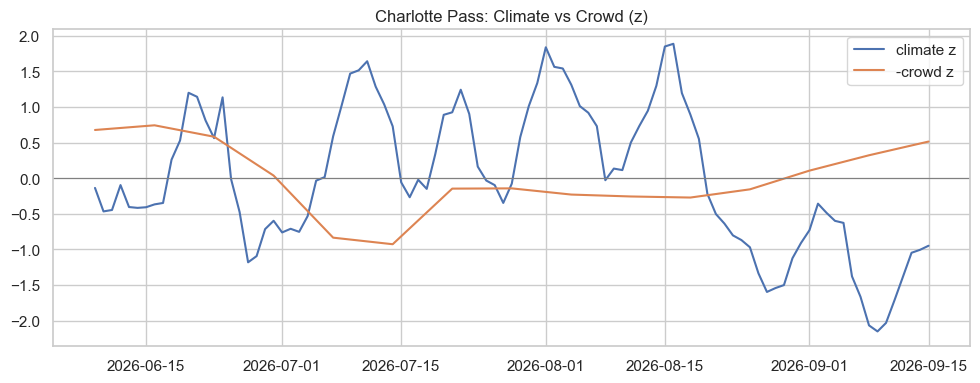

In [51]:
# Step 14 — Display top-N and plot quick checks

# 14.1 Top 10 overall
cols = ["Resort", "window_start", "window_end", "climate_mean", "crowd_z_blended_nanfill", "price_proxy", "composite_score"]
show_cols = [c for c in cols if c in win_scored.columns]

top10 = win_scored.sort_values("composite_score", ascending=False).head(10)[show_cols]
print("Top 10 windows:")
print(top10.to_string(index=False))

# 14.2 Quick line plot: climate_mean_z vs date for a sample resort
try:
    import matplotlib.pyplot as plt
    sample_resort = win_scored["Resort"].unique()[0]
    sub = win_scored[win_scored["Resort"] == sample_resort].sort_values("window_start")
    plt.figure(figsize=(10,4))
    plt.plot(sub["window_start"], sub["climate_mean_z"], label="climate z")
    plt.plot(sub["window_start"], -sub["crowd_z_blended_nanfill"], label="-crowd z")
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.title(f"{sample_resort}: Climate vs Crowd (z)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting skipped:", e)



### Step 15 — Audience extension: events, amenities, and tailored rankings
We’ll load `events.csv` and `amenities.csv`, compute event overlaps per 7-day window, build Youth/Family fit scores, and produce audience-specific top-N alongside the general ranking.


In [52]:
# Step 15 — Load events & amenities, compute overlaps and audience fits

EVENTS_CSV = f"{DATA_DIR}/events.csv"
AMENITIES_CSV = f"{DATA_DIR}/amenities.csv"

def load_events(path):
    df = pd.read_csv(path, comment="#")
    # Parse dates
    df["start_date"] = pd.to_datetime(df["start_date"]).dt.date
    df["end_date"] = pd.to_datetime(df["end_date"]).dt.date
    # Normalize tags and types
    df["audience_tags"] = df["audience_tags"].astype(str).str.lower()
    df["impact_type"] = df["impact_type"].astype(str).str.lower()
    df["impact_strength"] = pd.to_numeric(df["impact_strength"], errors="coerce").fillna(0.0)
    return df

def load_amenities(path):
    df = pd.read_csv(path, comment="#")
    for col in ["beginner_friendly","ski_school_quality","nightlife","terrain_parks","family_services","access_ease"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").clip(0,1)
    return df

events = load_events(EVENTS_CSV)
amenities = load_amenities(AMENITIES_CSV)

print("Events rows:", len(events))
print(events.head())
print("Amenities rows:", len(amenities))
print(amenities.head())

# Compute event overlap features per resort×window

def window_overlap_days(ws, we, es, ee):
    latest_start = max(ws, es)
    earliest_end = min(we, ee + timedelta(days=1))  # inclusive end
    return max(0, (earliest_end - latest_start).days)

feat_rows = []
for _, row in win_scored.iterrows():
    resort = row["Resort"]
    ws = row["window_start"].date() if isinstance(row["window_start"], pd.Timestamp) else row["window_start"]
    we = row["window_end"].date() if isinstance(row["window_end"], pd.Timestamp) else row["window_end"]
    sub = events[events["resort"].str.lower() == resort.lower()]
    youth_attr = 0.0
    fam_attr = 0.0
    youth_disc = 0.0
    fam_disc = 0.0
    for _, ev in sub.iterrows():
        ov_days = window_overlap_days(ws, we, ev["start_date"], ev["end_date"])
        if ov_days <= 0:
            continue
        frac = ov_days / 7.0
        if "youth" in ev["audience_tags"]:
            if ev["impact_type"] == "attracts":
                youth_attr += frac * ev["impact_strength"]
            elif ev["impact_type"] == "discount":
                youth_disc += frac * ev["impact_strength"]
        if "family" in ev["audience_tags"]:
            if ev["impact_type"] == "attracts":
                fam_attr += frac * ev["impact_strength"]
            elif ev["impact_type"] == "discount":
                fam_disc += frac * ev["impact_strength"]
    feat_rows.append({
        "Resort": resort,
        "window_start": row["window_start"],
        "window_end": row["window_end"],
        "event_attract_youth": youth_attr,
        "event_attract_family": fam_attr,
        "discount_youth": youth_disc,
        "discount_family": fam_disc,
    })

audience_feat = pd.DataFrame(feat_rows)

win_aud = win_scored.merge(audience_feat, on=["Resort","window_start","window_end"], how="left").merge(
    amenities, left_on="Resort", right_on="resort", how="left"
)
win_aud.drop(columns=["resort"], inplace=True)

# Build audience fit scores (clip to 0..1 after weighted sum is optional)
win_aud["Youth_fit"] = (
    0.35*win_aud["nightlife"].fillna(0)
    + 0.25*win_aud["terrain_parks"].fillna(0)
    + 0.20*win_aud["event_attract_youth"].fillna(0)
    + 0.20*win_aud["discount_youth"].fillna(0)
)
win_aud["Family_fit"] = (
    0.30*win_aud["beginner_friendly"].fillna(0)
    + 0.25*win_aud["ski_school_quality"].fillna(0)
    + 0.20*win_aud["family_services"].fillna(0)
    + 0.15*win_aud["access_ease"].fillna(0)
    + 0.10*win_aud["discount_family"].fillna(0)
)

# Standardize fits within resort for fair weighting
for col in ["Youth_fit","Family_fit"]:
    win_aud[col+"_z"] = win_aud.groupby("Resort")[col].transform(lambda s: (s - s.mean()) / (s.std() if s.std() else 1.0))

# Audience composites (weights can be tuned)
win_aud["composite_youth"] = (
    0.35*win_aud["climate_mean_z"].fillna(0)
    + 0.20*(-win_aud["crowd_z_blended_nanfill"].fillna(0))
    + 0.10*(-win_aud["price_proxy_z"].fillna(0))
    + 0.35*win_aud["Youth_fit_z"].fillna(0)
)
win_aud["composite_family"] = (
    0.35*win_aud["climate_mean_z"].fillna(0)
    + 0.35*(-win_aud["crowd_z_blended_nanfill"].fillna(0))
    + 0.10*(-win_aud["price_proxy_z"].fillna(0))
    + 0.20*win_aud["Family_fit_z"].fillna(0)
)

# Show top 5 per audience
print("Top 5 — Youth:")
print(win_aud.sort_values("composite_youth", ascending=False).head(5)[[
    "Resort","window_start","window_end","composite_youth","climate_mean_z","Youth_fit_z","crowd_z_blended_nanfill","price_proxy_z"
]])

print("\nTop 5 — Family:")
print(win_aud.sort_values("composite_family", ascending=False).head(5)[[
    "Resort","window_start","window_end","composite_family","climate_mean_z","Family_fit_z","crowd_z_blended_nanfill","price_proxy_z"
]])



Events rows: 4
        resort          event_name  start_date    end_date audience_tags  \
0      Thredbo            Uni Week  2026-07-22  2026-07-29         youth   
1  Falls Creek  Kids Snow Festival  2026-07-01  2026-07-07        family   
2     Perisher   Spring Music Fest  2026-09-05  2026-09-12         youth   
3   Mt. Buller     Family Fun Week  2026-07-08  2026-07-14        family   

  impact_type  impact_strength  
0    attracts              0.7  
1    discount              0.5  
2    attracts              0.6  
3    discount              0.4  
Amenities rows: 9
         resort  beginner_friendly  ski_school_quality  nightlife  \
0   Mt. Baw Baw                0.7                 0.6        0.3   
1  Mt. Stirling                0.5                 0.4        0.2   
2    Mt. Hotham                0.6                 0.7        0.7   
3   Falls Creek                0.8                 0.8        0.6   
4    Mt. Buller                0.7                 0.8        0.8   

   ter

### Step 16 — Window-level holiday overlap, event-driven uplift, and side-by-side rankings
We refine price/crowd proxies over the full 7-day window, apply event-driven adjustments, recompute composites, and print top-10 tables for General, Youth, and Family.


In [53]:
# Step 16 — Implement window-level overlaps and event-driven uplifts

# 16.1 Holiday overlap across the full 7-day window
def window_holiday_overlap(ws, we):
    vic = HOLIDAYS_2026["VIC_T2"]
    nsw = HOLIDAYS_2026["NSW_T2"]
    vic_days = window_overlap_days(ws, we, vic["start"], vic["end"])  # inclusive handled earlier in event code
    nsw_days = window_overlap_days(ws, we, nsw["start"], nsw["end"])  # both are already date objects
    return vic_days/7.0, nsw_days/7.0

win_aud["vic_overlap_window"], win_aud["nsw_overlap_window"] = zip(*win_aud.apply(
    lambda r: window_holiday_overlap(
        r["window_start"].date() if isinstance(r["window_start"], pd.Timestamp) else r["window_start"],
        r["window_end"].date() if isinstance(r["window_end"], pd.Timestamp) else r["window_end"]
    ), axis=1))

# 16.2 Event-driven uplift to crowd and discount to price
# Parameters (tunable)
ATTRACTS_TO_CROWD_Z = 0.25  # per unit event_attract over window
DISCOUNT_TO_PRICE_Z = -0.25 # per unit discount over window (negative lowers price)

# Compute combined audience-agnostic signals (max across youth/family for uplift; conservative)
win_aud["event_attract_any"] = win_aud[["event_attract_youth","event_attract_family"]].fillna(0).max(axis=1)
win_aud["discount_any"] = win_aud[["discount_youth","discount_family"]].fillna(0).max(axis=1)

# Baseline blended crowd and price from Step 13
base_crowd_z = win_aud["crowd_z_blended_nanfill"].copy()
base_price_z = win_aud["price_proxy_z"].copy()

# Apply uplifts
win_aud["crowd_z_adj"] = base_crowd_z + ATTRACTS_TO_CROWD_Z * win_aud["event_attract_any"].fillna(0)
win_aud["price_proxy_z_adj"] = base_price_z + DISCOUNT_TO_PRICE_Z * win_aud["discount_any"].fillna(0) \
    + 0.75*(win_aud["vic_overlap_window"].fillna(0) + win_aud["nsw_overlap_window"].fillna(0))  # holiday surcharge

# 16.3 Recompute General, Youth, Family composites with adjusted proxies (standardized)
# Re-standardize adjusted proxies per resort for fairness
z = lambda s: (s - s.mean()) / (s.std() if s.std() else 1.0)
win_aud["crowd_z_adj_std"] = win_aud.groupby("Resort")["crowd_z_adj"].transform(z)
win_aud["price_proxy_z_adj_std"] = win_aud.groupby("Resort")["price_proxy_z_adj"].transform(z)

# Normalize General weights to sum to 1
_w_c, _w_cr, _w_pr = 0.40, 0.30, 0.15
s = _w_c + _w_cr + _w_pr
w_c, w_cr, w_pr = _w_c/s, _w_cr/s, _w_pr/s

win_aud["composite_general_std"] = (
    w_c*win_aud["climate_mean_z"].fillna(0)
    + w_cr*(-win_aud["crowd_z_adj_std"].fillna(0))
    + w_pr*(-win_aud["price_proxy_z_adj_std"].fillna(0))
)

win_aud["composite_youth_std"] = (
    0.35*win_aud["climate_mean_z"].fillna(0)
    + 0.20*(-win_aud["crowd_z_adj_std"].fillna(0))
    + 0.10*(-win_aud["price_proxy_z_adj_std"].fillna(0))
    + 0.35*win_aud["Youth_fit_z"].fillna(0)
)

win_aud["composite_family_std"] = (
    0.35*win_aud["climate_mean_z"].fillna(0)
    + 0.35*(-win_aud["crowd_z_adj_std"].fillna(0))
    + 0.10*(-win_aud["price_proxy_z_adj_std"].fillna(0))
    + 0.20*win_aud["Family_fit_z"].fillna(0)
)

# Optional: dataset-level standardization and 0–100 percentile scores
for comp in ["composite_general_std","composite_youth_std","composite_family_std"]:
    win_aud[comp+"_z"] = (win_aud[comp] - win_aud[comp].mean()) / (win_aud[comp].std() if win_aud[comp].std() else 1.0)
    win_aud[comp+"_p100"] = win_aud[comp].rank(pct=True)*100.0

# 16.4 Side-by-side top-10 tables (standardized)
cols_gen = ["Resort","window_start","window_end","composite_general_std","climate_mean_z","crowd_z_adj_std","price_proxy_z_adj_std","composite_general_std_p100"]
cols_y = ["Resort","window_start","window_end","composite_youth_std","climate_mean_z","Youth_fit_z","crowd_z_adj_std","price_proxy_z_adj_std","composite_youth_std_p100"]
cols_f = ["Resort","window_start","window_end","composite_family_std","climate_mean_z","Family_fit_z","crowd_z_adj_std","price_proxy_z_adj_std","composite_family_std_p100"]

print("Top 10 — General:")
print(win_aud.sort_values("composite_general_std", ascending=False).head(10)[cols_gen].to_string(index=False))
print("\nTop 10 — Youth:")
print(win_aud.sort_values("composite_youth_std", ascending=False).head(10)[cols_y].to_string(index=False))
print("\nTop 10 — Family:")
print(win_aud.sort_values("composite_family_std", ascending=False).head(10)[cols_f].to_string(index=False))



Top 10 — General:
        Resort window_start window_end  composite_general_std  climate_mean_z  crowd_z_adj_std  price_proxy_z_adj_std  composite_general_std_p100
    Mt. Hotham   2026-06-20 2026-06-27               1.362332        1.526095        -1.547524              -0.555249                  100.000000
       Thredbo   2026-06-09 2026-06-16               1.335816        1.455698        -1.566257              -0.555249                   99.887767
      Perisher   2026-06-21 2026-06-28               1.311288        1.481424        -1.500251              -0.479666                   99.775533
      Perisher   2026-06-20 2026-06-27               1.310293        1.412757        -1.551195              -0.555249                   99.663300
    Mt. Hotham   2026-06-21 2026-06-28               1.240317        1.332252        -1.498063              -0.479666                   99.551066
    Mt. Hotham   2026-06-19 2026-06-26               1.202770        1.149929        -1.596985            

### Step 17 — Visuals pack and exports
We’ll render:
- Heatmaps of General/Youth/Family composites (resorts × start date)
- 2026 weekly visitors curve by resort with VIC/NSW holiday shading
- Climate uncertainty ribbon (p20–p80) for a selected resort
- Save PNGs to `figures/`


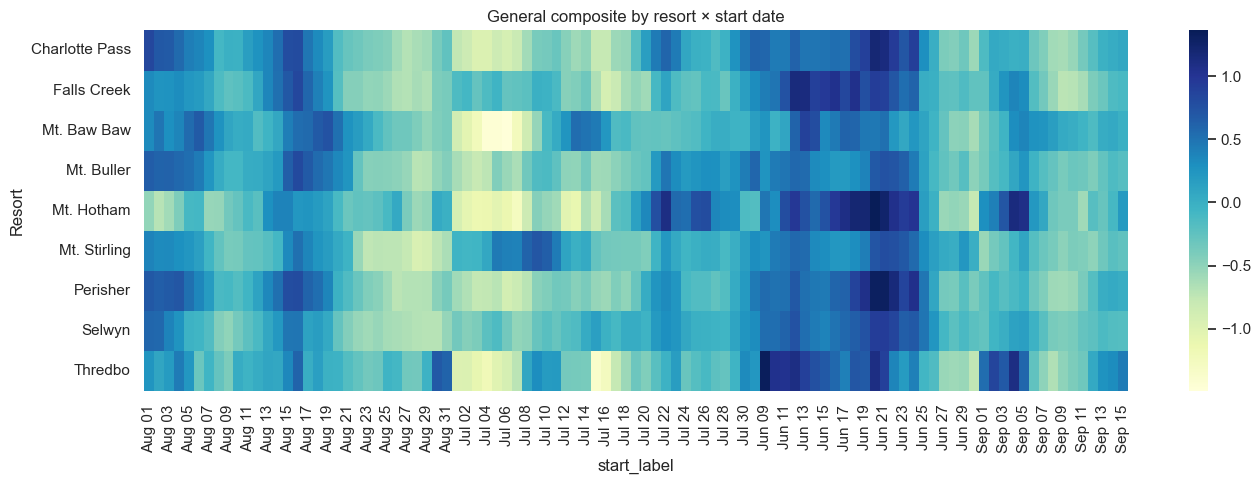

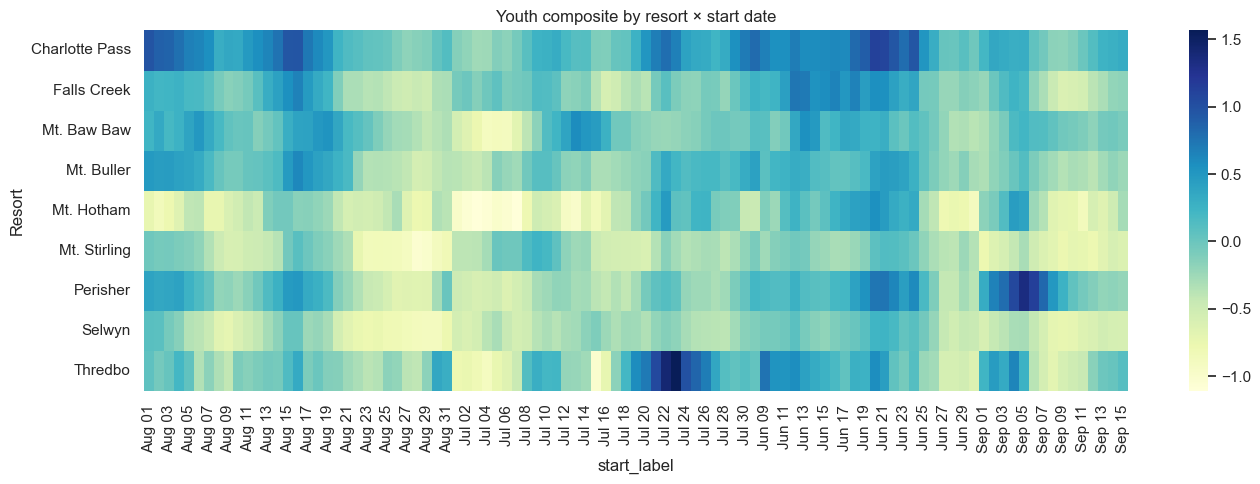

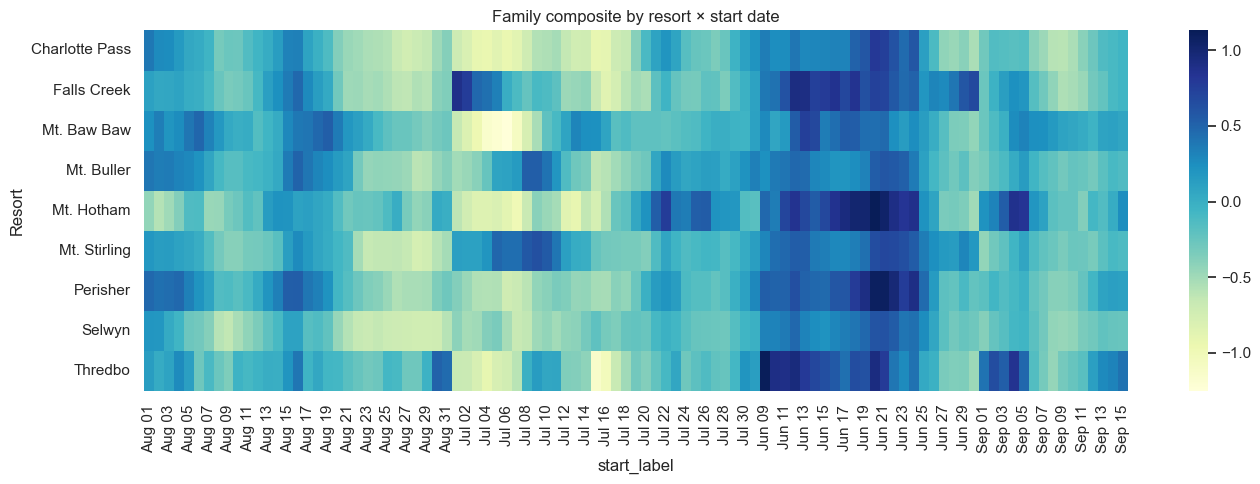

Saved figures to: /Users/neildadhich/Desktop/Datathon/figures


In [54]:
# Step 17 — Code to generate visuals and export PNGs
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme(style="whitegrid")

# Ensure figures dir
FIG_DIR = f"{DATA_DIR}/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# 17.1 Heatmaps for General/Youth/Family (using standardized composites)
for comp, title in [
    ("composite_general_std", "General"),
    ("composite_youth_std", "Youth"),
    ("composite_family_std", "Family"),
]:
    tmp = win_aud.copy()
    tmp["start_label"] = pd.to_datetime(tmp["window_start"]).dt.strftime('%b %d')
    # pivot: resorts rows, start dates columns
    piv = tmp.pivot_table(index="Resort", columns="start_label", values=comp, aggfunc="max")
    plt.figure(figsize=(14, 5))
    sns.heatmap(piv, cmap="YlGnBu", annot=False)
    plt.title(f"{title} composite by resort × start date")
    plt.tight_layout()
    out = os.path.join(FIG_DIR, f"heatmap_{title.lower()}.png")
    plt.savefig(out, dpi=180)
    plt.show()


print("Saved figures to:", FIG_DIR)

